In [2]:
# Loading the class data from the package pandas_datareader
from pandas_datareader import data

C:\Users\Chaitanya\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.width', 1000)


In [80]:
# First day
start_date='2016-01-01'
# Last day
end_date="2020-01-01"
# Call the function Datareader from the class data
goog_data=data.DataReader('GOOG','yahoo',start_date,end_date)

In [81]:
# print the GOOG data
print(goog_data)

                   High          Low         Open        Close   Volume    Adj Close
Date                                                                                
2015-12-31   769.500000   758.340027   769.500000   758.880005  1500900   758.880005
2016-01-04   744.059998   731.257996   743.000000   741.840027  3272800   741.840027
2016-01-05   752.000000   738.640015   746.450012   742.580017  1950700   742.580017
2016-01-06   747.179993   728.919983   730.000000   743.619995  1947000   743.619995
2016-01-07   738.500000   719.059998   730.309998   726.390015  2963700   726.390015
...                 ...          ...          ...          ...      ...          ...
2019-12-24  1350.260010  1342.780029  1348.500000  1343.560059   347500  1343.560059
2019-12-26  1361.327026  1344.469971  1346.170044  1360.400024   667500  1360.400024
2019-12-27  1364.530029  1349.310059  1362.989990  1351.890015  1038400  1351.890015
2019-12-30  1353.000000  1334.020020  1350.000000  1336.140015  1

In [82]:
# Create a dataframe for trading signals

goog_data_signal=pd.DataFrame(index=goog_data.index)

goog_data_signal["price"]=goog_data["Adj Close"]

goog_data_signal["daily_difference"]=goog_data_signal.price.diff()

goog_data_signal["signal"]=0
goog_data_signal["signal"]=np.where(goog_data_signal["daily_difference"]>0,1,0)

goog_data_signal["positions"]=goog_data_signal["signal"].diff()

In [83]:
print(goog_data_signal.head(10))

                 price  daily_difference  signal  positions
Date                                                       
2015-12-31  758.880005               NaN       0        NaN
2016-01-04  741.840027        -17.039978       0        0.0
2016-01-05  742.580017          0.739990       1        1.0
2016-01-06  743.619995          1.039978       1        0.0
2016-01-07  726.390015        -17.229980       0       -1.0
2016-01-08  714.469971        -11.920044       0        0.0
2016-01-11  716.030029          1.560059       1        1.0
2016-01-12  726.070007         10.039978       1        0.0
2016-01-13  700.559998        -25.510010       0       -1.0
2016-01-14  714.719971         14.159973       1        1.0


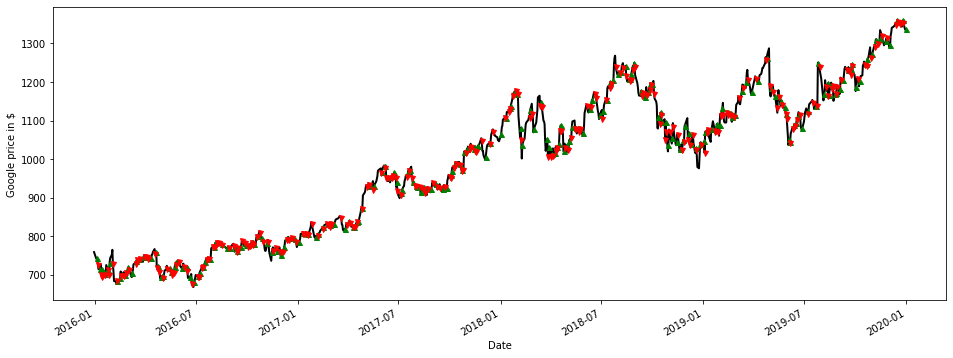

In [84]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(111,ylabel="Google price in $")
goog_data_signal["price"].plot(ax=ax1,color="k",lw=2)
ax1.plot(goog_data_signal.loc[goog_data_signal["positions"]==1].index,goog_data_signal.price[goog_data_signal.positions==1],"^",markersize=5,color="green")
ax1.plot(goog_data_signal.loc[goog_data_signal["positions"]==-1].index,goog_data_signal.price[goog_data_signal.positions==-1],"v",markersize=5,color="red")

In [85]:
def drawdown(return_series: pd.Series):
    """
    Takes a time series of asset returns
    Computes and returns a DataFrame that contains:
    the wealth index
    the previous peaks
    percent drawdowns
    """
    wealth_index=1000*(1+return_series).cumprod()
    previous_peaks=wealth_index.cummax()
    drawdowns=(wealth_index-previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth":wealth_index,
        "Peaks":previous_peaks,
        "Drawdown":drawdowns
    })
    

# Backtesting

In [86]:
# Declare the initial capital

initial_capital=float(1500.0)
# Create a dataframe for positions and portfolio

positions=pd.DataFrame(index=goog_data_signal.index).fillna(0.0)
portfolio=pd.DataFrame(index=goog_data_signal.index).fillna(0.0)

# Store the GOOG positions in the portfolio

positions["GOOG"]=goog_data_signal["signal"]
portfolio["positions"]=(positions.multiply(goog_data_signal["price"],axis=0))#It accounts the positions at the end of day.

# Calculate the non-invested money(cash)

portfolio["cash"]=initial_capital-(positions.diff().multiply(goog_data_signal.price,axis=0)).cumsum()#It contains the cashout at the end of day when the stock was sold
portfolio["total"]=portfolio["cash"]+portfolio["positions"]

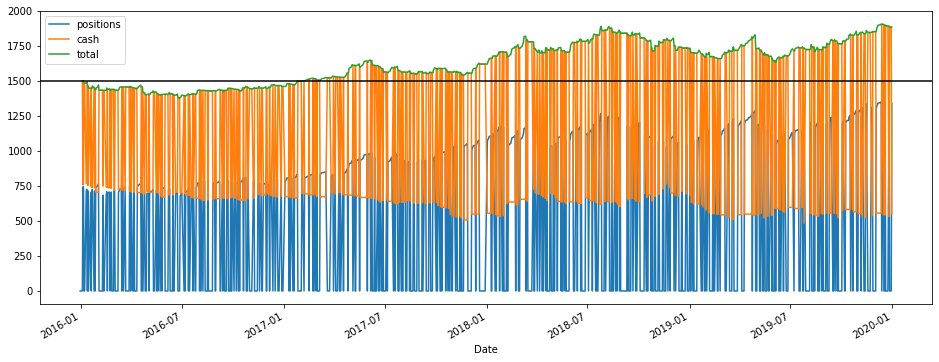

In [87]:
portfolio.plot(figsize=(16,6))
plt.axhline(y=initial_capital,color="k")

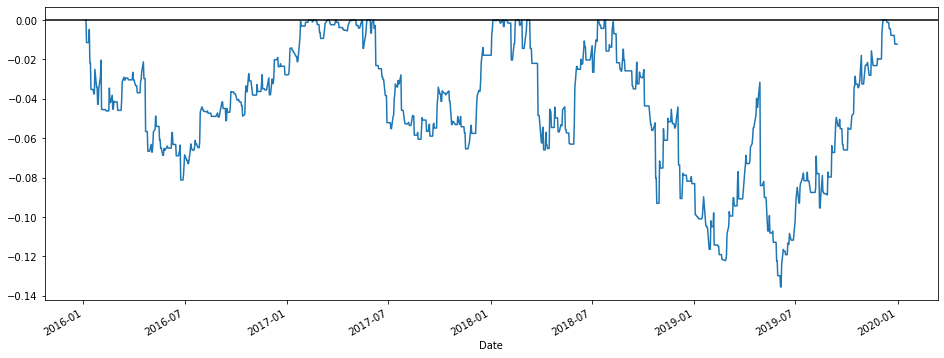

In [88]:
drawdown(portfolio["total"].pct_change().dropna())["Drawdown"].plot(figsize=(16,6))
plt.axhline(y=0,color="k")

In [89]:
drawdown(portfolio["total"].pct_change().dropna())["Drawdown"].min()

-0.13550613192347466

In [90]:
drawdown(portfolio["total"].pct_change().dropna())["Drawdown"].idxmin()

Timestamp('2019-06-05 00:00:00')

In [91]:
(((np.prod(portfolio["total"].pct_change().dropna()+1))**(1/portfolio["total"].pct_change().dropna().shape[0])-1)-0.03)/portfolio["total"].pct_change().dropna().std()

-5.173680868202289

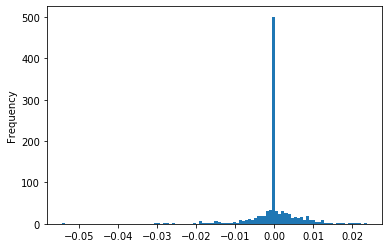

In [92]:
(portfolio["total"].pct_change().dropna()).plot.hist(bins=100)

In [93]:
import scipy.stats

In [94]:
# Jarque- bera test for normality
scipy.stats.jarque_bera(portfolio["total"].pct_change().dropna())

(6999.819977542194, 0.0)

In [95]:
# Skewness in the data
scipy.stats.skew(portfolio["total"].pct_change().dropna())

-1.3484564512826354

In [96]:
# Return at the end of the period
np.prod((1+portfolio["total"].pct_change().dropna()))

1.2551295572916665

In [98]:
portfolio["total"].pct_change().dropna()

Date
2016-01-05    0.000000
2016-01-06    0.000693
2016-01-07   -0.011479
2016-01-08    0.000000
2016-01-11    0.000000
                ...   
2019-12-24    0.000000
2019-12-26    0.000000
2019-12-27   -0.004500
2019-12-30    0.000000
2019-12-31    0.000000
Name: total, Length: 1005, dtype: float64

In [99]:
#CAGR
((np.prod((1+portfolio["total"].pct_change().dropna())))**(252/1005)-1)*100

5.863387658015928